# WMT of tendency terms
## Table Of Contents: <a class="anchor" id="top"> </a>
* [Make histogram of each term](#first-bullet)
* [Save histograms](#second-bullet)

# 1) Make histogram of each term <a class='anchor' id='first-bullet'> </a>

In [1]:
import xarray as xr
import numpy as np
import dask.array as dsa
import matplotlib.pyplot as plt
import fastjmd95
import pop_tools
import gcsfs
from xhistogram.xarray import histogram

In [2]:
from intake import open_catalog
url = "https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/CESM_POP.yaml"
cat = open_catalog(url)
ds  = cat["CESM_POP_hires_control"].to_dask()

In [3]:
import json
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

tendencies = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CESM/datasets/tendencies.zarr')).drop(['nlon', 'nlat'])
tendencies

<xarray.Dataset>
Dimensions:    (time: 182, nlat: 2400, nlon: 3600)
Coordinates:
  * time       (time) object 0046-01-02 00:00:00 ... 0046-07-02 00:00:00
Dimensions without coordinates: nlat, nlon
Data variables:
    SSS_bih    (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    SST_bih    (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    cabbeling  (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    drhods     (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    drhodt     (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    rho_bih    (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>

In [13]:
from dask_gateway import Gateway
gateway = Gateway()
options = gateway.cluster_options()

# set the options programatically, or through their HTML repr
options.worker_memory = 30  # 10 GB of memory per worker.

# Create a cluster with those options
cluster = gateway.new_cluster(options)
cluster.scale(30)
client = cluster.get_client()

In [14]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/staging.7fbce90f59984438b2b408d328db25cd/status,


In [95]:
client.close()
cluster.close()

In [16]:
rho_unsliced = fastjmd95.rho(ds.SSS, ds.SST, 0)
rho = rho_unsliced.isel(time=slice(0,182))

In [32]:
area = ds.TAREA * ds.dz * 1e-4 #convert cm^2 to m^2
delta_rho = 0.01
rho_bins = np.arange(1015, 1030, delta_rho)

In [35]:
tendency_terms = xr.merge([(tendencies.SST_bih*tendencies.drhodt).rename('sst'), 
                           (tendencies.SSS_bih*tendencies.drhods).rename('sss'), 
                            tendencies.rho_bih.rename('rho'), 
                            tendencies.cabbeling.rename('cabbeling')])

In [36]:
all_tendencies = list(tendency_terms)

In [50]:
def histogram_func(variable):
    """Generalized xhistogram's histogram function 
    for mixing tendency terms"""
    hist = histogram(rho.rename('rho0'), bins=[rho_bins],
                     weights=(variable.fillna(0.)*ds.TAREA), dim=['nlon', 'nlat'])
    return hist / delta_rho

In [51]:
histograms = xr.merge([histogram_func(tendency_terms[var]).rename('OMEGA_' + var)
                      for var in all_tendencies])

In [52]:
histograms

<xarray.Dataset>
Dimensions:          (time: 182, rho0_bin: 1499)
Coordinates:
  * time             (time) object 0046-01-02 00:00:00 ... 0046-07-02 00:00:00
  * rho0_bin         (rho0_bin) float64 1.015e+03 1.015e+03 ... 1.03e+03
Data variables:
    OMEGA_sst        (time, rho0_bin) float64 dask.array<chunksize=(1, 1499), meta=np.ndarray>
    OMEGA_sss        (time, rho0_bin) float64 dask.array<chunksize=(1, 1499), meta=np.ndarray>
    OMEGA_rho        (time, rho0_bin) float64 dask.array<chunksize=(1, 1499), meta=np.ndarray>
    OMEGA_cabbeling  (time, rho0_bin) float64 dask.array<chunksize=(1, 1499), meta=np.ndarray>

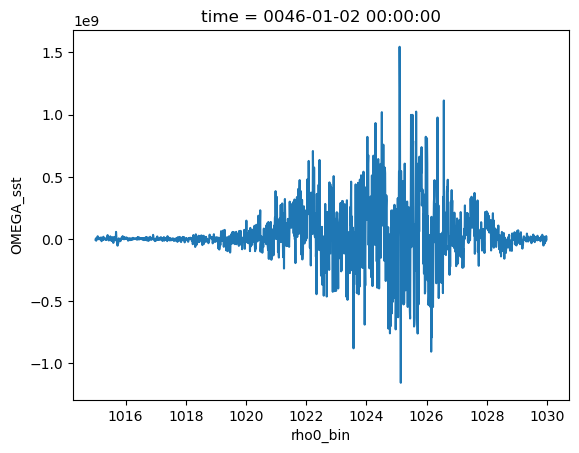

In [53]:
histograms.OMEGA_sst[0].plot()

In [54]:
histograms.load()

<xarray.Dataset>
Dimensions:          (time: 182, rho0_bin: 1499)
Coordinates:
  * time             (time) object 0046-01-02 00:00:00 ... 0046-07-02 00:00:00
  * rho0_bin         (rho0_bin) float64 1.015e+03 1.015e+03 ... 1.03e+03
Data variables:
    OMEGA_sst        (time, rho0_bin) float64 -6.331e+06 3.664e+06 ... 3.28e+06
    OMEGA_sss        (time, rho0_bin) float64 1.502e+07 ... -3.444e+04
    OMEGA_rho        (time, rho0_bin) float64 8.783e+06 -1.223e+07 ... 3.111e+06
    OMEGA_cabbeling  (time, rho0_bin) float64 -9.339e+04 8.209e+03 ... 1.351e+05

# 2) Save histograms <a class='anchor' id='second-bullet'> </a>

In [55]:
#saving monthly climatology histograms
gcsmap_hist = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CESM/datasets/histograms.zarr')
histograms.to_zarr(gcsmap_hist, mode='w')

[Back to top](#top)